In [1]:
#import packages
import os
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

#variables:
new_txt_date=False

In [2]:
#Create dataframe from parliament-txt transcripts
# Run 1 time only
#dialogsDF

def create_table_from_txt(txt_path="./discursos"):
    dialogsDF = pd.DataFrame()

    #regex expressions to extract speakers
    SPEAKER_REGEX = re.compile(r'[A|O] Sr\.ª?( [\w\-,]+)+([\-\w]+)?( \([\w\s\.,\-]+\))*(?=:)')
    MULTILINE_SPEAKER_REGEX = re.compile("^" + SPEAKER_REGEX.pattern, flags=re.M) 
    c=0
    for file in os.scandir(txt_path):
        speech_by_speaker = []

        with open(file, encoding="utf8") as fp:
            content = fp.read()
        
            #1)extract dates and numbers

            dates_txt = re.compile("\d{1,2} [A-Z]+ [A-Z]+ [A-Z]+ \d{4} (\n\n\d+)?")
            dates_txt.sub(" ", content)

            series_numb = re.compile("[A-Z]+ SÉRIE \W NÚMERO \d+ (\n+\d+)?")
            series_numb.sub(" ", content)

            deputies = MULTILINE_SPEAKER_REGEX.finditer(content) 
            deputies = [match.group() for match in deputies]
            deputies = list(set(deputies))

            content_on_one_line = ''.join(content.splitlines())

            for speaker in deputies:
                content_split_by_speaker = content_on_one_line.split(speaker + ':')
                # Get rid of everything before they speak
                content_split_by_speaker.pop(0)

                # what_they_say = [speech for speech in speaker_regex]
                # for each line in content_split_by_speaker
                # use the speaker regex to find the next speaker and get everything before that
                for line in content_split_by_speaker:
                    start_of_next_speaker = SPEAKER_REGEX.finditer(line)

                    # either an index or None
                    # if it's None, either:
                    # - the regex isn't accurate enough; or
                    # - the speaker is the only person to speak]
                    next_speaker_indexes = [match.start() for match in start_of_next_speaker]
                    next_speaker_index = next_speaker_indexes[0] if len(next_speaker_indexes) > 0 else None

                    speech = line[0:next_speaker_index] if next_speaker_index is not None else line
                    speech_by_speaker.append((speaker, speech))

                    # if "):" in speech:
                    #     print(speech)
            
            df = pd.DataFrame.from_records(speech_by_speaker, columns=["speaker", "speech"])#.reset_index()
            df['filename'] = os.path.basename(file)
            #print(df)
                    
            dialogsDF = pd.concat([dialogsDF, df])
    dialogsDF.to_pickle('dialogsDF.pkl')  
    return 'Saved in this directory as dialogsDF.pkl'
#conjunto_dados#.to_csv("deputados.csv")#, index=False)
    

In [3]:
if new_txt_date==True:
    create_table_from_txt()
    dialogsDF = pd.read_pickle('dialogsDF.pkl')
else:
    # load dataframe with speaches
    dialogsDF = pd.read_pickle('dialogsDF.pkl')  

In [4]:
#see it
print(dialogsDF.shape)
dialogsDF.tail(3)

(151340, 3)


,speaker,speech,filename
114,A Sr.ª Presidente (Edite Estrela),"— Srs. Deputados, está em apreciação o parece...",darl14sl03n031.txt
115,O Sr. Miguel Arrobas (CDS-PP),"— Sr.ª Presidente, Srs. Membros do Governo, S...",darl14sl03n031.txt
116,O Sr. Miguel Arrobas (CDS-PP),"— Vou concluir, Sr.ª Presidente. Sr. Ministro...",darl14sl03n031.txt


In [5]:
def remove_punctuation(col_name, df):
    df[col_name]=df[col_name].str.replace('[^\w\s]', '')
    print('Punctuation removed')
    return df

def remove_special_char(col_name, df, char1,char2):
    df[col_name]=df[col_name].str.replace(char1,char2)
    print('Character '+char1 + 'replaced by '+ char2)
    return df

def aux_remove_accents(a):
    import unidecode
    return unidecode.unidecode(a)

def remove_accents(col_name, df ):
    df[col_name] = df[col_name].apply(aux_remove_accents)
    print('Accents removed')
    return df

def date_format(df, date_col, old_format="%d/%m/%Y", new_format="%Y-%m-%Y"):
    import datetime
    df[date_col] = pd.to_datetime(df[date_col], format =old_format)
    df[date_col] = pd.to_datetime(df[date_col], format =new_format)
    df[date_col]= df['Date'].dt.date
    return df

In [6]:
# 1 Speakers selection
#remove ministers, secretaries, presidents' dialogs
dialogsDF['clean_speaker']=dialogsDF['speaker'].str.lower()
dialogsDF= remove_special_char('clean_speaker', dialogsDF, 'ç','c') #dialogsDF['clean_speaker'].str.replace('ç','c')
dialogsDF= remove_punctuation('clean_speaker', dialogsDF) #dialogsDF['clean_speaker'].str.replace('[^\w\s]', '')
dialogsDF= remove_accents('clean_speaker', dialogsDF)
dialogsDF = dialogsDF[~dialogsDF['clean_speaker'].str.contains('secretari*', na=False)]
dialogsDF = dialogsDF[~dialogsDF['clean_speaker'].str.contains('ministr*', na=False)]
dialogsDF = dialogsDF[~dialogsDF['clean_speaker'].str.contains('presidente*', na=False)]
dialogsDF.drop('clean_speaker',  axis=1, inplace=True)
# 1.1 Speakers cleaning name
aux = dialogsDF["speaker"].str.split("(", n=1, expand=True)
aux.columns = ["speaker", "party"]
dialogsDF["speaker"] = aux["speaker"].str.replace(r"[A|O] Sr\.ª? ", "")
dialogsDF["speaker"] = dialogsDF["speaker"].str.rstrip(" ")
dialogsDF['speaker'] = dialogsDF['speaker'].str.lower()
dialogsDF= remove_special_char('speaker', dialogsDF, 'ç','c') #dialogsDF['clean_speaker'].str.replace('ç','c')
dialogsDF= remove_punctuation('speaker', dialogsDF) #dialogsDF['clean_speaker'].str.replace('[^\w\s]', '')
dialogsDF= remove_accents('speaker', dialogsDF)
dialogsDF['speaker'] = dialogsDF['speaker'].str.replace('^a ', '')
dialogsDF['speaker'] = dialogsDF['speaker'].str.replace(' e ', '')
dialogsDF['speaker'] = dialogsDF['speaker'].str.replace(' ', '')
#2 speach data cleaning
dialogsDF["speech"] = [string.lstrip("— ") for string in dialogsDF["speech"]]
dialogsDF['speech'] = dialogsDF['speech'].str.lower()
dialogsDF= remove_special_char('speech', dialogsDF, 'ç','c') #dialogsDF['clean_speaker'].str.replace('ç','c')
dialogsDF= remove_punctuation('speech', dialogsDF) #dialogsDF['clean_speaker'].str.replace('[^\w\s]', '')
dialogsDF= remove_accents('speech', dialogsDF)

# 3 creation of number columns
dialogsDF['number']=[ii[11:14] for ii in dialogsDF.filename]
dialogsDF['number']=pd.to_numeric(dialogsDF['number'],errors='coerce')
dialogsDF['session']=[ii[8:10] for ii in dialogsDF.filename]
dialogsDF['session']=pd.to_numeric(dialogsDF['session'],errors='coerce')
dialogsDF['term']=[ii[4:6] for ii in dialogsDF.filename]
dialogsDF['term']=pd.to_numeric(dialogsDF['term'],errors='coerce')

# 4 creation of party column
dialogsDF["party"] = aux["party"].str.rstrip(")")
# 5 creation of dates column for each parliament session 
dates_term=pd.read_csv('dates_terms.csv')
dates_term['number']=pd.to_numeric(dates_term['number'],errors='coerce')
dates_term=dates_term.dropna()
dialogsDF=dialogsDF.merge(dates_term, on=['term','session','number'], how='left')
# 6 date format
dialogsDF=date_format(dialogsDF, 'Date')
# 7 creation of link 
strnumb = lambda x : '00'+str(x) if(x <10) else ('0'+str(x) if x < 100 else x) 
dialogsDF['link_numb']=dialogsDF.number.apply( strnumb)
dialogsDF['link']='https://debates.parlamento.pt/catalogo/r3/dar/01/'+dialogsDF.term.map(str) +'/0'+ dialogsDF.session.map(str)+'/'+ dialogsDF.link_numb.map(str) +'/'+ dialogsDF.Date.map(str)
dialogsDF.drop('link_numb',  axis=1, inplace=True)

Character çreplaced by c


C:\Users\trind\AppData\Local\Temp\ipykernel_6352\2309341446.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col_name]=df[col_name].str.replace('[^\w\s]', '')


Punctuation removed
Accents removed


C:\Users\trind\AppData\Local\Temp\ipykernel_6352\3081346599.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  dialogsDF["speaker"] = aux["speaker"].str.replace(r"[A|O] Sr\.ª? ", "")


Character çreplaced by c


C:\Users\trind\AppData\Local\Temp\ipykernel_6352\2309341446.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col_name]=df[col_name].str.replace('[^\w\s]', '')


Punctuation removed
Accents removed


C:\Users\trind\AppData\Local\Temp\ipykernel_6352\3081346599.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  dialogsDF['speaker'] = dialogsDF['speaker'].str.replace('^a ', '')


Character çreplaced by c
Punctuation removed
Accents removed


In [7]:
dialogsDF.head()

,speaker,speech,filename,number,session,term,party,Date,link
0,josemanuelpureza,muito bem,darl13sl01n001.txt,1,1,13,BE,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...
1,teresalealcoelho,muito bem,darl13sl01n001.txt,1,1,13,PSD,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...
2,luismontenegro,muito bom dia a todos sras e srs deputados cum...,darl13sl01n001.txt,1,1,13,PSD,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...
3,luismontenegro,o seu exemplo de tolerancia imparcialidade de ...,darl13sl01n001.txt,1,1,13,PSD,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...
4,luismontenegro,sr presidente o grupo parlamentar do psd indic...,darl13sl01n001.txt,1,1,13,PSD,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...


In [8]:
# 8 selection of parties, unique names

dialogsDF.loc[dialogsDF["party"] == "PEN", "party"] = 'PAN'

dialogsDF.loc[dialogsDF["party"] == "OS Verdes", "party"] = 'PEV'
dialogsDF.loc[dialogsDF["party"] == "Os verdes", "party"] = 'PEV'
dialogsDF.loc[dialogsDF["party"] == "Os Vedes", "party"] = 'PEV'
dialogsDF.loc[dialogsDF["party"] == "Os Verdes", "party"] = 'PEV'
dialogsDF.loc[dialogsDF["party"] == "s Verdes", "party"] = 'PEV'

dialogsDF.loc[dialogsDF["party"] == "SD", "party"] = 'PSD'
dialogsDF.loc[dialogsDF["party"] == "PD", "party"] = 'PSD'

dialogsDF.loc[dialogsDF["party"] == "CDS", "party"] = 'CDS-PP'
dialogsDF.loc[dialogsDF["party"] == "CSD-PP", "party"] = 'CDS-PP'
dialogsDF.loc[dialogsDF["party"] == "CDS-P", "party"] = 'CDS-PP'

dialogsDF.loc[dialogsDF["party"] == "PC", "party"] = 'PCP'

dialogsDF.loc[dialogsDF["party"] == "B E", "party"] = 'BE'
dialogsDF.loc[dialogsDF["party"] == "Bloco de Esquerda", "party"] = 'BE'

dialogsDF.loc[dialogsDF["party"] == "Partido Socialista", "party"] = 'PS'

dialogsDF.loc[dialogsDF["party"] == "N insc.", "party"] = "N insc"
dialogsDF.loc[dialogsDF["party"] == "N Insc.", "party"] = "N insc"
dialogsDF.loc[dialogsDF["party"] == "Ninsc.", "party"] = "N insc"
dialogsDF.loc[dialogsDF["party"] == "N. insc.", "party"] = "N insc"
dialogsDF.loc[dialogsDF["party"] == "Não insc.", "party"] = "N insc"

# 8.1 remove speaches without party
dialogsDF = dialogsDF[dialogsDF.party!='N insc']

In [9]:
# 8.2 wrongly assigned speakers to parties, correction
dialogsDF.loc[(dialogsDF.speaker=='tiagobarbosaribeiro')  & (dialogsDF.party=='CDS-PP'),'party']='PS'
dialogsDF.loc[(dialogsDF.speaker=='telmocorreia')  & (dialogsDF.party=='PSD'),'party']='CDS-PP'
dialogsDF.loc[(dialogsDF.speaker=='sandracunha')  & (dialogsDF.party=='PSD'),'party']='BE'
dialogsDF.loc[(dialogsDF.speaker=='ruicruz')  & (dialogsDF.party=='PS'),'speaker']='joseruicruz'
dialogsDF.loc[(dialogsDF.speaker=='pedromotasoares')  & (dialogsDF.party=='PCP'),'party']='CDS-PP'
dialogsDF.loc[(dialogsDF.speaker=='pedrofilipesoares')  & (dialogsDF.party=='CDS-PP'),'party']='BE'
dialogsDF.loc[(dialogsDF.speaker=='pedrocoimbra')  & (dialogsDF.party=='PSD'),'party']='PS'
dialogsDF.loc[(dialogsDF.speaker=='telmocorreia')  & (dialogsDF.party=='PSD'),'party']='CDS-PP'
dialogsDF.loc[(dialogsDF.speaker=='pedroalves')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='nunoserra')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='mariamanuelrola')  & (dialogsDF.party=='PS'),'party']='BE'

dialogsDF.loc[(dialogsDF.speaker=='luismonteiro')  & (dialogsDF.party=='PSD'),'party']='BE'
dialogsDF.loc[(dialogsDF.speaker=='luisleiteramos')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='luiscapoulassantos')  & (dialogsDF.party=='PSD'),'party']='PS'
dialogsDF.loc[(dialogsDF.speaker=='luiscamposferreira')  & (dialogsDF.party=='PS'),'party']='PSD'

dialogsDF.loc[(dialogsDF.speaker=='josesilvano')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='joseluisferreira')  & (dialogsDF.party=='BE'),'party']='PEV'
dialogsDF.loc[(dialogsDF.speaker=='jorgeoliveira')  & (dialogsDF.party=='PCP'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='jorgepaulooliveira')  & (dialogsDF.party=='PCP'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='joaopinhodealmeida')  & (dialogsDF.party=='PSD'),'party']='CDS-PP'
dialogsDF.loc[(dialogsDF.speaker=='joaooliveira')  & (dialogsDF.party=='BE'),'party']='PCP'
dialogsDF.loc[(dialogsDF.speaker=='joaogoncalvespereira')  & (dialogsDF.party=='PSD'),'party']='CDS-PP'
dialogsDF.loc[(dialogsDF.speaker=='hugocarvalho')  & (dialogsDF.party=='PSD'),'party']='PS'
dialogsDF.loc[(dialogsDF.speaker=='hortensemartins')  & (dialogsDF.party=='PSD'),'party']='PS'

dialogsDF.loc[(dialogsDF.speaker=='pedrosoares')  & (dialogsDF.party=='CDS-PP'),'party']='BE'
dialogsDF.loc[(dialogsDF.speaker=='patriciafonseca')  & (dialogsDF.party=='PSD'),'party']='CDS-PP'
dialogsDF.loc[(dialogsDF.speaker=='heitordesousa')  & (dialogsDF.party=='PCP'),'party']='BE'
dialogsDF.loc[(dialogsDF.speaker=='heitordesousa')  & (dialogsDF.party=='PSD'),'party']='BE'
dialogsDF.loc[(dialogsDF.speaker=='fernandonegrao')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='duartemarques')  & (dialogsDF.party=='PCP'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='dianaferreira')  & (dialogsDF.party=='PSD'),'party']='PCP'
dialogsDF.loc[(dialogsDF.speaker=='claramarquesmendes')  & (dialogsDF.party=='CDS-PP'),'party']='PSD'

dialogsDF.loc[(dialogsDF.speaker=='carlossantossilva')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='brunodias')  & (dialogsDF.party=='PS'),'party']='PCP'
dialogsDF.loc[(dialogsDF.speaker=='brunovitorino')  & (dialogsDF.party=='CDS-PP'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='brunodias')  & (dialogsDF.party=='BE'),'party']='PCP'
dialogsDF.loc[(dialogsDF.speaker=='bebianacunha')  & (dialogsDF.party=='BE'),'party']='PAN'
dialogsDF.loc[(dialogsDF.speaker=='antoniofilipe')  & (dialogsDF.party=='BE'),'party']='PCP'

dialogsDF.loc[(dialogsDF.speaker=='antoniocostasilva')  & (dialogsDF.party=='BE'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='angelaguerra')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='andreventura')  & (dialogsDF.party=='PS'),'party']='CH'
dialogsDF.loc[(dialogsDF.speaker=='andreventura')  & (dialogsDF.party=='BE'),'party']='CH'
dialogsDF.loc[(dialogsDF.speaker=='andrepinotesbatista')  & (dialogsDF.party=='PSD'),'party']='PS'
dialogsDF.loc[(dialogsDF.speaker=='andrecoelholima')  & (dialogsDF.party=='CDS-PP'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='anamesquita')  & (dialogsDF.party=='PS'),'party']='PCP'
dialogsDF.loc[(dialogsDF.speaker=='anacatarinamendoncamendes')  & (dialogsDF.party=='BE'),'party']='PS'

dialogsDF.loc[(dialogsDF.speaker=='afonsooliveira')  & (dialogsDF.party=='PS'),'party']='PSD'
dialogsDF.loc[(dialogsDF.speaker=='anacatariamendoncamendes')  & (dialogsDF.party=='BE'),'party']='PS'
dialogsDF.loc[(dialogsDF.speaker=='anacatariamendoncamendes')  & (dialogsDF.party=='PSD'),'party']='PS'
dialogsDF.loc[(dialogsDF.speaker=='anamesquita')  & (dialogsDF.party=='PS'),'party']='PCP'
dialogsDF.loc[(dialogsDF.speaker=='anacatarinamendoncamendes')  & (dialogsDF.party=='BE'),'party']='PS'

In [10]:
# 9 unique speaker name creation for ID
variations_deputies=('paulosa','catarinamarcelina','joaopulocorreia','duartefilipemarques','duartemaques', 'adaosiva', 'alexandraviera', 'alvarocastelobranco','amadeussoaresalbergaria','anacatariamendoncamendes','anacatarianamendoncamendes','anacatarinamendes','anacatarinamendocamendes','anacatarinamendonca','anacatarinamendoncamendes','anacatarinamendoncamendes','anacatarinamendoncamendes','catarinamendoncamendes','anamiguelsantos','anavirginia', 'andrepinotesbaptista','antoniotropa','euricobrilhantesdias','felicianobareirasduarte','fernandorocha','heitorsousa','hugosoareslopes','idaliaserrao','inesdesousaleal','inesdomingues','jorgeoliveira','jorgepaulodeoliveira','josesoeiro', 'laramarinho','marcosperestello','marcosperestrelo','mariaantoniadealmeidasantos','mariadasmercessoares','mariamercesborges','mariamercessoares','manuelatender','mariamortagua','marizabelmoutela','marizabelmoutela','nelsonbasiliosilva','pedrofilipesores','pedrofilipesoares','vaniabarros','verabras','cristinadejesus')
unique_name_deputes=('catarinamarcelino','joaopaulocorreia','duartemarques','duartemarques','adaosilva','alexandravieira', 'alvarocastellobranco','amadeusoaresalbergaria' ,'anacatariamendoncamendes','anacatariamendoncamendes','anacatariamendoncamendes','anacatariamendoncamendes','anacatariamendoncamendes','anacatariamendoncamendes','anacatariamendoncamendes','anacatariamendoncamendes','anacatariamendoncamendes','anamigueldossantos','anavirginiapereira','andrepinotesbatista','antoniotopa','euricobrilhantedias','felicianobarreirasduarte','fernandorochaandrade','heitordesousa','hugolopessoares','idaliasalvadorserrao' ,'inesdesousareal','inesdomingos','jorgepaulooliveira','jorgepaulooliveira','josemourasoeiro','laramartinho','marcosperestrello','marcosperestrello','mariaantoniaalmeidasantos','mariadasmercessoares','mariadasmercessoares','mariadasmercessoares','mariamanuelatender','marianamortagua','marisabelmoutela','marisabelmoutela','nelsonsilva','pedrosoares','pedrosoares','vaniadiasdasilva','verabraz','cristinajesus')

replace_map = dict(zip(variations_deputies, unique_name_deputes))
dialogsDF['speaker']=dialogsDF['speaker'].replace(replace_map)



In [11]:
# 10 Extract shy speakers (speak less tha 5 times in 7 years)
aux1=pd.DataFrame(dialogsDF.groupby(['speaker','party']).size()).add_suffix('count').reset_index()
shy_speakers=aux1[aux1['0count']<5].speaker.to_list()
dialogsDF=dialogsDF[~dialogsDF.speaker.isin(shy_speakers)]

In [12]:
# 11 assign missing parties, delete none/nan/null parties 
aux1.columns=['speaker', 'partyR', '0count']
df2=dialogsDF.merge(aux1, on=['speaker'], how='left')
df2=df2[~df2.partyR.isna()]
df2.drop('party', axis=1, inplace=True)
df2 = df2.rename({'partyR': 'party', '0count': 'speaker_ntime'}, axis=1)

In [13]:
df2.head(3)

,speaker,speech,filename,number,session,term,Date,link,party,speaker_ntime
0,josemanuelpureza,muito bem,darl13sl01n001.txt,1,1,13,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...,BE,891.0
1,teresalealcoelho,muito bem,darl13sl01n001.txt,1,1,13,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...,PSD,87.0
2,luismontenegro,muito bom dia a todos sras e srs deputados cum...,darl13sl01n001.txt,1,1,13,2015-10-23,https://debates.parlamento.pt/catalogo/r3/dar/...,PSD,694.0


In [14]:
# 12 Add genre of each deputie
#pd.DataFrame(df2.speaker.unique(), columns=['speaker']).to_csv('genre_speakers.csv')
#zero for M and 1 for F, manually added
genre_speakers=pd.read_csv('genre_speakers.csv')
genre_speakers=genre_speakers.fillna(0)
#add to main df
df3=df2.merge(genre_speakers, on=['speaker'], how='left')
#replace 0/1 for M/F
genre_numb=(0.0,1.0)
genre_name=('M','F')
replace_mapG = dict(zip(genre_numb, genre_name))
df3['genre']=df3['genre'].replace(replace_mapG)

In [15]:
# 13 add number of words
df3['len_speech']=df3.speech.str.split().str.len()
df3['year'] = pd.DatetimeIndex(df3['Date']).year
aux2=df3.groupby([ 'year','genre']).agg({'len_speech':'sum'}).unstack().reset_index().droplevel(level=0, axis=1)
aux2.columns=['year','F', 'M']

aux5=df3.groupby([ 'year']).agg({'len_speech':'sum'}).reset_index()

In [16]:
df3.to_pickle('parliament_fdf.pkl')

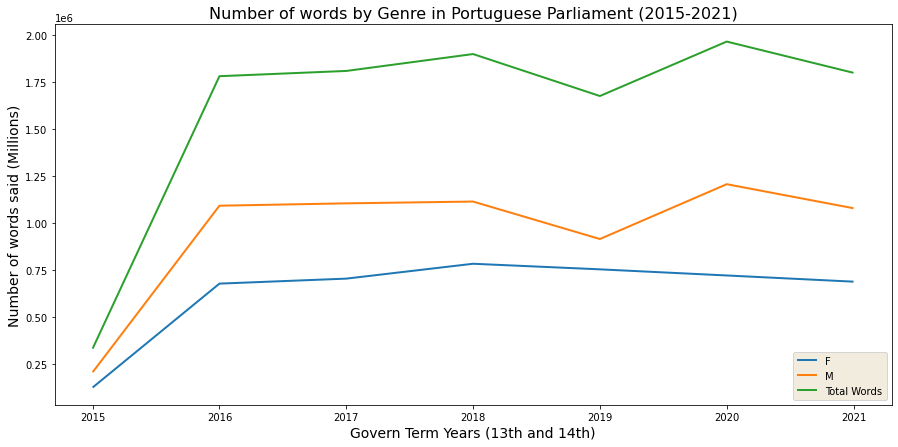

In [17]:
# PLOT WORDS
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Scores')
plt.title('Scores by group and gender')
df3.groupby([ 'year','genre']).agg({'len_speech':'sum'}).unstack()


x = np.linspace(0, 10)
with plt.style.context('Solarize_Light2'):
    plt.plot(aux2.year, aux2.F)
    plt.plot(aux2.year, aux2.M)
    plt.plot(aux2.year, aux5.len_speech)
    
    # Number of accent colors in the color scheme
    plt.title('Number of words by Genre in Portuguese Parliament (2015-2021)')
    plt.xlabel('Govern Term Years (13th and 14th)', fontsize=14)
    plt.ylabel('Number of words said (Millions)', fontsize=14)
    plt.legend(['F','M','Total Words'],loc='lower right')
  
plt.show()

In [18]:
#Number of Speackers per Party per Year

df3.groupby([ 'year','party']).agg({'speaker':'nunique'}).unstack().reset_index().droplevel(level=0, axis=1)

party,,BE,CDS-PP,CH,IL,L,PAN,PCP,PEV,PS,PSD
0,2015,16.0,17.0,NaN,NaN,NaN,2.0,13.0,2.0,51.0,51.0
1,2016,18.0,18.0,NaN,NaN,NaN,2.0,14.0,2.0,80.0,81.0
2,2017,19.0,16.0,NaN,NaN,NaN,2.0,14.0,2.0,82.0,85.0
3,2018,20.0,17.0,NaN,NaN,NaN,2.0,17.0,2.0,84.0,88.0
4,2019,22.0,18.0,1.0,1.0,1.0,4.0,16.0,3.0,109.0,117.0
5,2020,17.0,8.0,1.0,1.0,1.0,4.0,11.0,2.0,104.0,79.0
6,2021,16.0,9.0,2.0,1.0,NaN,2.0,10.0,2.0,96.0,75.0


In [19]:
aux4=df3.groupby([ 'year','party']).agg({'len_speech':'sum'}).unstack().reset_index().droplevel(level=0, axis=1)

In [20]:
aux4.columns=['year', 'BE', 'CDS-PP', 'CH', 'IL', 'L', 'PAN', 'PCP', 'PEV', 'PS', 'PSD']

In [21]:
aux4

,year,BE,CDS-PP,CH,IL,L,PAN,PCP,PEV,PS,PSD
0,2015,49441.0,57497.0,NaN,NaN,NaN,7629.0,57453.0,20294.0,67471.0,70761.0
1,2016,259336.0,313277.0,NaN,NaN,NaN,44986.0,293498.0,137360.0,355471.0,376873.0
2,2017,274068.0,331331.0,NaN,NaN,NaN,52434.0,302390.0,128614.0,343210.0,376734.0
3,2018,290050.0,352873.0,NaN,NaN,NaN,49867.0,320056.0,122557.0,379654.0,383680.0
4,2019,244494.0,309623.0,10584.0,6870.0,1649.0,49816.0,276299.0,111817.0,323175.0,340958.0
5,2020,245850.0,262829.0,80928.0,76633.0,536.0,122037.0,299791.0,148881.0,374448.0,353183.0
6,2021,214921.0,248748.0,67906.0,58160.0,NaN,88836.0,279145.0,141700.0,356638.0,342747.0


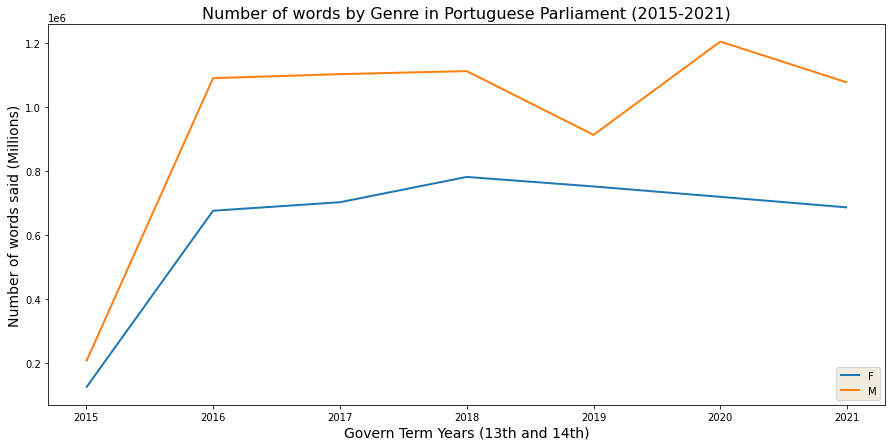

In [22]:
# PLOT WORDS
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Scores')
plt.title('Scores by group and gender')
df3.groupby([ 'year','genre']).agg({'len_speech':'sum'}).unstack()

import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 10)
with plt.style.context('Solarize_Light2'):
    plt.plot(aux2.year, aux2.F)
    plt.plot(aux2.year, aux2.M)
    
    # Number of accent colors in the color scheme
    plt.title('Number of words by Genre in Portuguese Parliament (2015-2021)')
    plt.xlabel('Govern Term Years (13th and 14th)', fontsize=14)
    plt.ylabel('Number of words said (Millions)', fontsize=14)
    plt.legend(['F','M'],loc='lower right')
  
plt.show()

In [23]:
genre_speakers

,speaker,genre
0,abelbaptista,0.0
1,adaosilva,0.0
2,afonsooliveira,0.0
3,albertofonseca,0.0
4,albertomachado,0.0
...,...,...
368,ulissespereira,0.0
369,vaniadiasdasilva,1.0
370,verabraz,1.0
371,vitalinocanas,1.0
